In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import signal,stats
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.trials import select_trials
from ephysvibe.spike_sorting import config
from collections import defaultdict
from typing import Dict
from statsmodels import api as sm
from statsmodels.formula.api import ols
from bioinfokit. analys import stat as bk_stat
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

## Block 1

In [43]:
py_filepath = "/home/INT/losada.c/Documents/data/test/lip/lip/2022-11-22_10-59-03_Riesling_lip_e1_r1.npy"
#2022-12-14_10-50-49_Riesling_lip_e1_r1

#### Load file

In [44]:
py_f = np.load(py_filepath,allow_pickle=True).item(0)
sp_py = py_f['sp_data']
bhv = py_f['bhv']
print('sp_py keys:')
print(sp_py.keys())
print('bhv_py trial keys:')
print(bhv[0].keys())

sp_py keys:
dict_keys(['sp_samples', 'blocks', 'code_numbers', 'code_samples', 'eyes_values', 'lfp_values', 'samples', 'clusters_id', 'clusters_ch', 'clustersgroup', 'clusterdepth'])
bhv_py trial keys:
dict_keys(['trial', 'AbsoluteTrialStartTime', 'Btn1', 'Btn10', 'Btn2', 'Btn3', 'Btn4', 'Btn5', 'Btn6', 'Btn7', 'Btn8', 'Btn9', 'Eye', 'Eye2', 'EyeExtra', 'Gen1', 'Gen10', 'Gen11', 'Gen12', 'Gen13', 'Gen14', 'Gen15', 'Gen16', 'Gen2', 'Gen3', 'Gen4', 'Gen5', 'Gen6', 'Gen7', 'Gen8', 'Gen9', 'Joystick', 'Joystick2', 'KeyInput', 'Mouse', 'PhotoDiode', 'SampleInterval', 'Touch', 'CodeNumbers', 'CodeTimes', 'Block', 'BlockCount', 'Condition', 'CycleRate', 'Angle', 'BackgroundColor', 'Info', 'Position1', 'Position2', 'Position3', 'Position4', 'Position5', 'Position6', 'Scale', 'Status', 'Time', 'Zorder', 'ReactionTime', 'EndTimes', 'StartTimes', 'Attribute11', 'Attribute12', 'Attribute13', 'Attribute21', 'Attribute22', 'Attribute23', 'Attribute24', 'Attribute25', 'Attribute26', 'Code', 'FrameByF

In [45]:
# Selec trials in a block
n_block = 1
trial_idx = select_trials.select_trials_block(sp_py,n_block)
# Selec correct trials
trial_idx = select_trials.select_correct_trials(bhv,trial_idx)
b_sp_samples = [sp_py['sp_samples'][i] for i in trial_idx]
print('Number of clusters: %d'%len(b_sp_samples[0]))

Number of trials in block 1: 1308
Number of correct trials in block 2: 574
Number of clusters: 16


In [46]:
# sample identity
# IN:
# A: (1o 1c) 1 - 7
# B: (1o 5c) 8 - 14
# C: (5o 1c) 15 - 21
# D: (5o 5c) 22 - 28 

In [47]:
condition = np.arange(1,57)
samples_cond = {
    # samples IN
    'a_in' : np.arange(1,8),
    'b_in' : np.arange(8,15),
    'c_in' : np.arange(15,22),
    'd_in' : np.arange(22,29),
}

In [48]:
def test_stim(task,bhv_idx):
    for key,value in bhv_idx.items():
        if 'Stim_Filename_' in key:
            val = value.item(0).decode('utf-8')
            if key[-1] == 'd': # distractor
                task['test_stimuli_'+key[-2:]] += [val[-11:-4]]
            else:
                task['test_stimuli_'+key[-1]] += [val[-11:-4]]
                n_test =  int(key[-1])

    for n in range(n_test+1,6):
        task['test_stimuli_'+str(n)] += ['']
        task['test_stimuli_'+str(n)+'d'] += ['']

    return task,n_test

In [49]:
def create_task_frame(trial_idx,bhv,samples_cond):
    task:Dict[str,list] = defaultdict(list)#{}
    for idx in trial_idx:
        task['idx_trial'] += [idx]
        cond = int(bhv[idx]['Condition'][0][0])
        a_out = samples_cond['a_in']+28
        b_out = samples_cond['b_in']+28
        c_out = samples_cond['c_in']+28
        d_out = samples_cond['d_in']+28
        # IN
        if cond in samples_cond['a_in']:
            task,n_test = test_stim(task,bhv[idx])
            sample_id = 'A'
            code = 7- (samples_cond['a_in'][-1]-cond)
            if code == 7:
                sample_id = 'N'
            task['sample_id'] += [sample_id]
            task['in_out'] += [1]
            task['n_test_stimuli'] += [n_test]
            task['code'] += [code]
        elif cond in samples_cond['b_in']:
            task,n_test = test_stim(task,bhv[idx])
            sample_id = 'B'
            code = 7- (samples_cond['b_in'][-1]-cond)
            if code == 7:
                sample_id = 'N'
            task['sample_id'] += [sample_id]
            task['in_out'] += [1]
            task['n_test_stimuli'] += [n_test]
            task['code'] += [code]
        elif cond in samples_cond['c_in']:
            task,n_test = test_stim(task,bhv[idx])
            sample_id = 'C'
            code = 7- (samples_cond['c_in'][-1]-cond)
            if code == 7:
                sample_id = 'N'
            task['sample_id'] += [sample_id]
            task['in_out'] += [1]    
            task['n_test_stimuli'] += [n_test]
            task['code'] += [code]
        elif cond in samples_cond['d_in']:
            task,n_test = test_stim(task,bhv[idx])
            sample_id = 'D'
            code = 7- (samples_cond['d_in'][-1]-cond)
            if code == 7:
                sample_id = 'N'
            task['sample_id'] += [sample_id]
            task['in_out'] += [1]    
            task['n_test_stimuli'] += [n_test]
            task['code'] += [code]
        # OUT
        elif cond in a_out:
            task,n_test = test_stim(task,bhv[idx])
            sample_id = 'A'
            code = 7- (a_out[-1]-cond)
            if code == 7:
                sample_id = 'N'
            task['sample_id'] += [sample_id]
            task['in_out'] += [-1]
            task['n_test_stimuli'] += [n_test]
            task['code'] += [code]
        elif cond in b_out:
            task,n_test = test_stim(task,bhv[idx])
            sample_id = 'B'
            code = 7- (b_out[-1]-cond)
            if code == 7:
                sample_id = 'N'
            task['sample_id'] += [sample_id]
            task['in_out'] += [-1]
            task['n_test_stimuli'] += [n_test]
            task['code'] += [code]
        elif cond in c_out:
            task,n_test = test_stim(task,bhv[idx])
            sample_id = 'C'
            code = 7- (c_out[-1]-cond)
            if code == 7:
                sample_id = 'N'
            task['sample_id'] += [sample_id]
            task['in_out'] += [-1]
            task['n_test_stimuli'] += [n_test]
            task['code'] += [code]
        elif cond in d_out:
            task,n_test = test_stim(task,bhv[idx])
            sample_id = 'D'
            code = 7- (d_out[-1]-cond)
            if code == 7:
                sample_id = 'N'
            task['sample_id'] += [sample_id]
            task['in_out'] += [-1]
            task['n_test_stimuli'] += [n_test]
            task['code'] += [code]

    return pd.DataFrame(task)

In [50]:
task=create_task_frame(trial_idx,bhv,samples_cond)

In [51]:
def info_task(task):
    fig,ax = plt.subplots(1,2,figsize=(10,4))
    data = task[['sample_id','in_out']].groupby(['sample_id','in_out'],as_index=False).size()
    sns.barplot(data=data,x='sample_id',y='size',hue='in_out',ax=ax[0])
    data = task[(task['in_out']==1)&(task['sample_id']!='N')][['sample_id','n_test_stimuli']].groupby(['sample_id','n_test_stimuli'],as_index=False).size()
    sns.barplot(data=data,x='sample_id',y='size',hue='n_test_stimuli',ax=ax[1])
    data = task.groupby(task.drop(['idx_trial','test_stimuli_1d','test_stimuli_2d','test_stimuli_3d','test_stimuli_4d','test_stimuli_5d'],inplace=False,axis=1).columns.to_list(),as_index=False).size()
    data=data[data['size']>1].replace('',float(np.nan))
    data.dropna(how='all',axis=1,inplace=True)
    data.sort_values(by=['sample_id','code','size'])
    return data

,test_stimuli_1,test_stimuli_2,test_stimuli_3,sample_id,in_out,n_test_stimuli,code,size
0,o_1_c_1,NaN,NaN,A,-1,1,1,19
1,o_1_c_1,NaN,NaN,A,1,1,1,18
15,o_1_c_1,o_5_c_5,NaN,D,1,2,2,2
16,o_1_c_1,o_5_c_6,o_5_c_1,C,-1,3,3,2
17,o_1_c_1,o_5_c_6,o_5_c_5,D,1,3,3,2
58,o_1_c_5,NaN,NaN,B,-1,1,1,13
59,o_1_c_5,NaN,NaN,B,1,1,1,13
60,o_1_c_5,o_1_c_1,NaN,A,-1,2,2,2
61,o_1_c_5,o_1_c_1,NaN,A,1,2,2,4
79,o_1_c_6,o_1_c_1,NaN,A,1,2,2,3


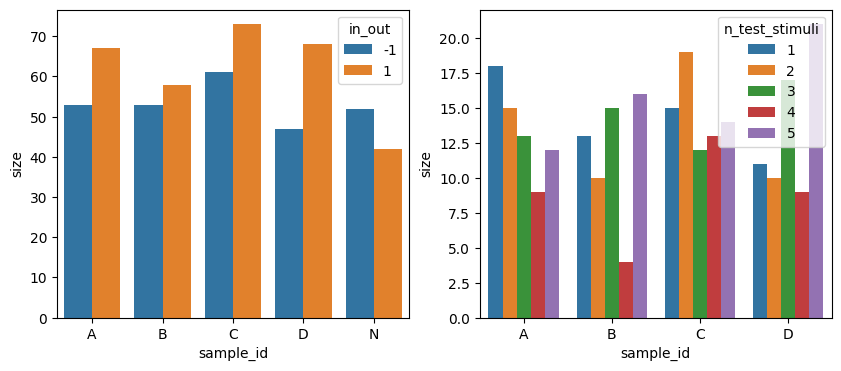

In [52]:
info_task(task)

In [53]:
stim_codes = {'A':'o_1_c_1','B':'o_1_c_5','C':'o_5_c_1','D':'o_5_c_5'}
# kernel parameters

w = 0.015 # seconds = 15 ms
w_size = 0.1 # seconds = 100ms

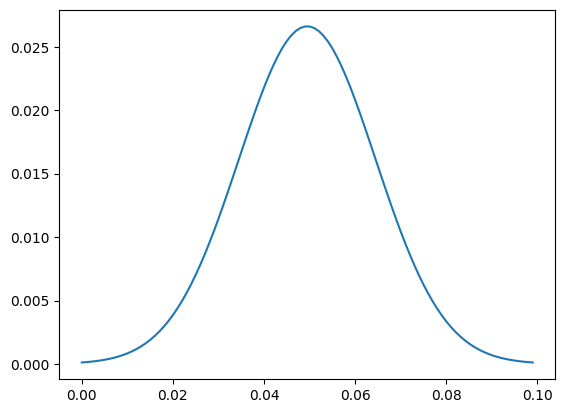

In [54]:
# define kernel for the convolution
fs_ds = config.FS/config.DOWNSAMPLE
kernel = signal.gaussian(M=w_size*fs_ds,std=w*fs_ds)
kernel=kernel/sum(kernel) # area of the kernel must be one
plt.plot(np.arange(len(kernel))/fs_ds,kernel)

In [55]:
events = {
    'start_trial':9,
    'fixation':8,
    'sample_on': 23,
    'sample_off': 24,
    'test_on_1': 25, 
    'test_off_1':26,
    'test_on_2': 27, 
    'test_off_2':28,
    'test_on_3': 29, 
    'test_off_3':30,
    'test_on_4': 31, 
    'test_off_4':32,
    'test_on_5': 33, 
    'test_off_5':34,
    'end_trial':18,
}

#### Check sample selectiviy


In [56]:
def fr_between_events(neuron_trials,kernel,fs,down_sample):
    if len(neuron_trials[0]) != 0:
        # Compute trial average fr
        trial_average_sp,sorted_sp_neuron = firing_rate.trial_average_fr(neuron_trials)    
        # Downsample to 1ms
        trial_average_sp =np.sum(np.concatenate((trial_average_sp,np.zeros(down_sample-len(trial_average_sp)%down_sample))).reshape(-1,down_sample),axis=1)
    else:
        trial_average_sp=[0]
        sorted_sp_neuron=[0]
    conv = np.convolve(trial_average_sp,kernel,mode='same')*fs   
    return conv,trial_average_sp, sorted_sp_neuron

In [57]:
palette={'A': 'firebrick', 'B': 'teal', 'C': 'tomato', 'D': 'turquoise', 'N': 'grey'}

In [58]:
task[(task['sample_id']=='A') & (task['in_out']==1)]

,idx_trial,test_stimuli_1,test_stimuli_1d,test_stimuli_2,test_stimuli_2d,test_stimuli_3,test_stimuli_3d,test_stimuli_4,test_stimuli_4d,test_stimuli_5,test_stimuli_5d,sample_id,in_out,n_test_stimuli,code
7,120,o_1_c_1,o_1_c_1,,,,,,,,,A,1,1,1
21,162,o_1_c_1,o_8_c_5,,,,,,,,,A,1,1,1
35,194,o_5_c_5,o_2_c_1,o_7_c_2,o_5_c_4,o_1_c_3,o_1_c_4,o_1_c_1,o_2_c_2,,,A,1,4,4
39,203,o_1_c_4,o_7_c_3,o_7_c_2,o_7_c_7,o_1_c_1,o_2_c_4,,,,,A,1,3,3
42,210,o_2_c_4,o_5_c_6,o_8_c_1,o_2_c_7,o_1_c_1,o_8_c_5,,,,,A,1,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531,1261,o_1_c_4,o_8_c_3,o_4_c_1,o_1_c_8,o_1_c_4,o_7_c_1,o_5_c_2,o_6_c_8,o_8_c_7,o_4_c_8,A,1,5,6
543,1292,o_8_c_1,o_3_c_5,o_2_c_2,o_2_c_5,o_1_c_1,o_7_c_8,,,,,A,1,3,3
550,1313,o_1_c_1,o_6_c_3,,,,,,,,,A,1,1,1
556,1326,o_1_c_1,o_7_c_1,,,,,,,,,A,1,1,1


In [59]:
def mean_fr_by_sample(sp_py,task,events,neurons,in_out,fs,downsample=1,plot=True,x_lim_min=-0.7,x_lim_max=5):
    fs = fs/downsample
    mean_fr:Dict[str,list] = defaultdict(list)
    for i,neuron in enumerate(neurons):
        total_events_timestamps = np.zeros((1,len(events))) 
        conv_max=0
        fig,ax = plt.subplots(figsize=(10, 3),sharex=True,sharey=True)
        for sample in ['A','B','C','D','N']:
            target_trials_idx = task[(task['sample_id']==sample) & (task['in_out']==in_out)]['idx_trial'].values
            events_timestamps = firing_rate.select_events_timestamps(sp_py,target_trials_idx, events) # select events timestamps for all trials
            neuron_trials = firing_rate.align_neuron_spikes(target_trials_idx, sp_py, neuron, events_timestamps[:,2])
            shift_events = (events_timestamps.T-events_timestamps.T[2]).T
            total_events_timestamps = np.concatenate((total_events_timestamps,shift_events))
            #mean_ev = np.nanmean(shift_events,axis=0)
            conv,trial_average_sp, sorted_sp_neuron = fr_between_events(neuron_trials,kernel,fs,downsample)
            conv_max=conv_max if conv_max > max(conv) else max(conv)
            # add values to dict
            ev = np.floor(np.nanmean((events_timestamps.T-events_timestamps.T[2]).T,axis=0)/downsample)[2:]
            if np.sum(conv)==0:
                conv_plot = np.zeros(max(ev)+1)
            else:
                conv_plot = conv[int(abs(sorted_sp_neuron[0])/downsample):]
            ev = np.floor(np.nanmean((events_timestamps.T-events_timestamps.T[2]).T,axis=0)/downsample)[2:]
            ev_a = np.zeros(len(conv_plot))
            ev_a[ev.tolist()]=1
            mean_fr['neuron'] += [i+1] * len(conv_plot)
            mean_fr['conv'] += conv_plot.tolist()
            mean_fr['mean_idx_events'] += ev_a.tolist()
            mean_fr['sample'] += [sample] * len(conv_plot)
            if plot:
                ax.plot((np.arange(len(conv))+sorted_sp_neuron[0]/downsample) / fs, conv,palette[sample])
        if plot:
            mean_idx_events = np.nanmean(total_events_timestamps[1:],axis=0)/downsample
            ax.vlines(mean_idx_events[0]/fs, 0, conv_max ,color="slategray", linestyles="dashdot")
            ax.vlines(mean_idx_events[1]/fs, 0, conv_max ,color="slategray", linestyles="dotted")
            ax.vlines(mean_idx_events[2]/fs, 0, conv_max ,color="k", linestyles="solid")
            ax.vlines(mean_idx_events[-1]/fs, 0, conv_max ,color="slategray", linestyles="dashdot")
            ax.vlines(mean_idx_events[3]/fs, 0, conv_max ,color="silver", linestyles="dashed")
            for n in range(4,len(events)-1,2):
                ax.vlines(mean_idx_events[n]/fs, 0, conv_max ,color="dimgray", linestyles="solid")
                ax.vlines(mean_idx_events[n+1]/fs, 0, conv_max ,color="silver", linestyles="dashed")
            ax.set_title('in_out: %d'%(in_out))
            ax.set_xlim(x_lim_min, x_lim_max)
            fig.legend(['Sample A','Sample B','Sample C','Sample D','Sample N','start_trial','Fixation','Sample on','end_trial','Off','On'], fontsize=9)
            fig.suptitle("Neuron %d" % (i + 1), x=0)
            plt.show()
            
    mean_fr_df=pd.DataFrame(mean_fr)
    return mean_fr_df


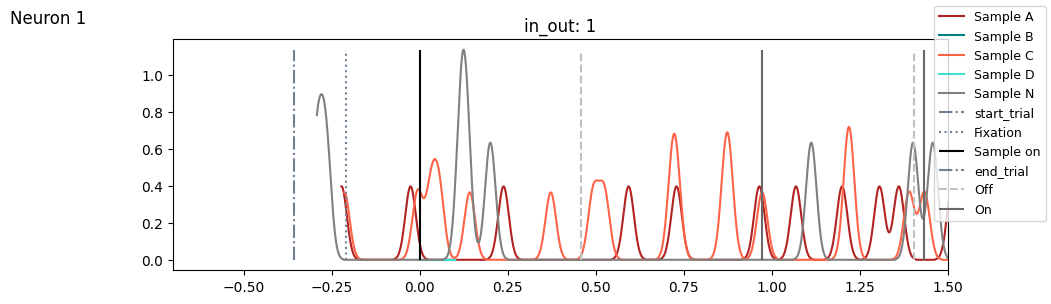

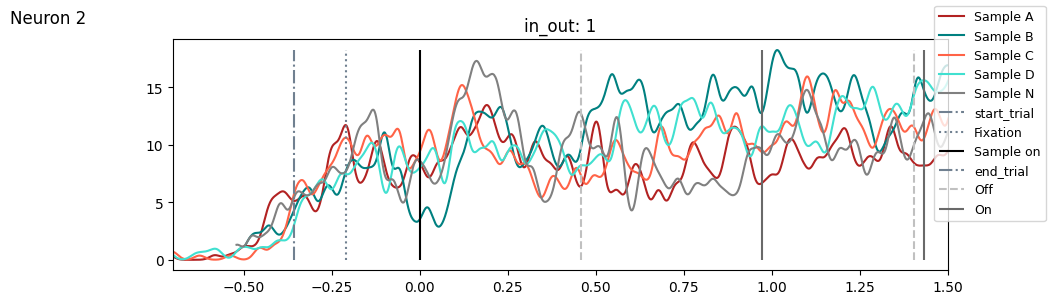

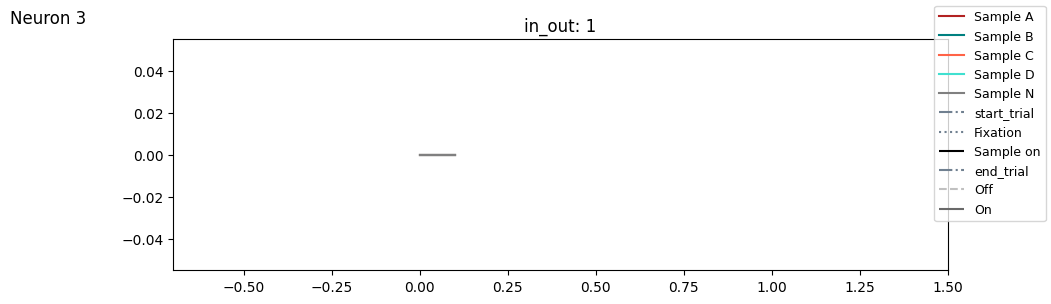

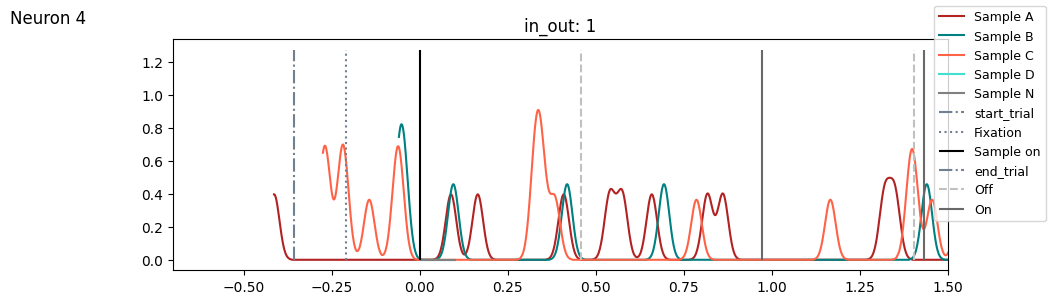

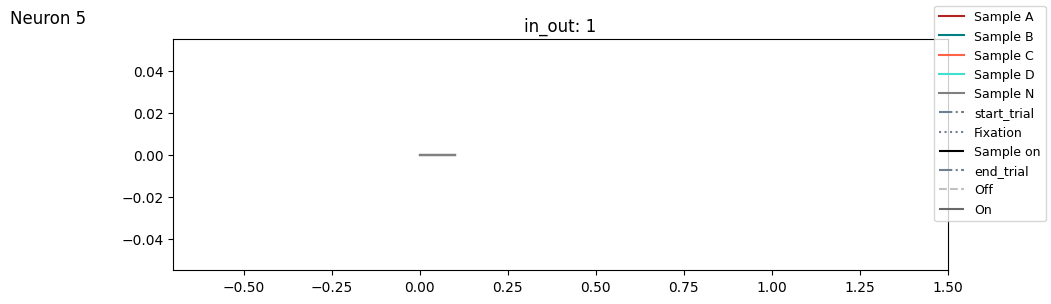

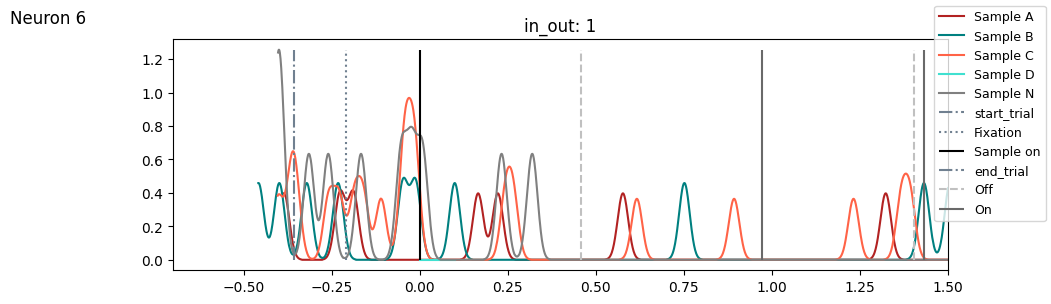

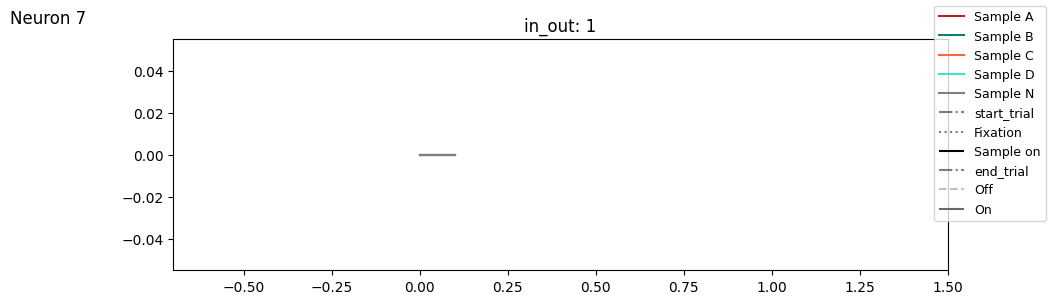

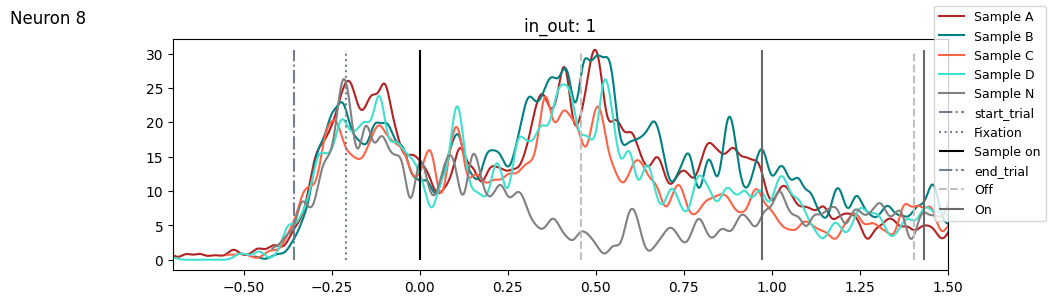

In [60]:
x_lim_max = 1.5
x_lim_min = -0.7
neurons = np.where(sp_py['clustersgroup']=='good')[0]
in_out=1
mean_fr_df = mean_fr_by_sample(sp_py,task,events,neurons,in_out,fs=config.FS,downsample=config.DOWNSAMPLE,x_lim_min=x_lim_min,x_lim_max=x_lim_max)

F_onewayResult(statistic=232.23959669359934, pvalue=1.7952668129444507e-167)


/home/INT/losada.c/.virtualenvs/EphysVibe-48n-7Gof/lib/python3.8/site-packages/bioinfokit/analys.py:402: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


,group1,group2,Diff,Lower,Upper,q-value,p-value
0,A,B,1.765994,0.908339,2.623650,7.949588,0.001000
1,A,C,0.831525,-0.026130,1.689181,3.743095,0.062632
2,A,D,0.473390,-0.384266,1.331046,2.130957,0.550296
3,A,N,7.118609,6.260953,7.976265,32.044279,0.001000
4,B,C,2.597520,1.739864,3.455175,11.692684,0.001000
5,B,D,2.239384,1.381729,3.097040,10.080545,0.001000
6,B,N,8.884603,8.026948,9.742259,39.993867,0.001000
7,C,D,0.358135,-0.499520,1.215791,1.612139,0.758403
8,C,N,6.287084,5.429428,7.144739,28.301183,0.001000
9,D,N,6.645219,5.787563,7.502875,29.913322,0.001000


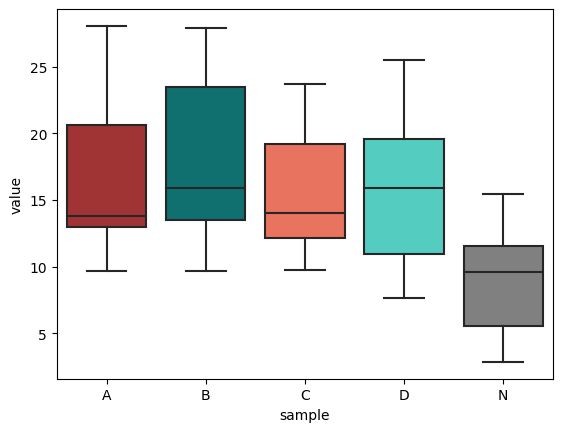

In [20]:
n_neuron = 8
anova_df = mean_fr_df[mean_fr_df['neuron']==n_neuron][['sample','conv','mean_idx_events']].reset_index(drop=True).reset_index()
df:Dict[str,list] = defaultdict(list)

for n_sample in ['A','B','C','D','N']: 
    a_df=anova_df[anova_df['sample']==n_sample].reset_index(drop=True)
    # idx events
    a_ev_idx = a_df.index[a_df['mean_idx_events']!=0].values 
    # conv between during sample presentation
    a_event = a_df['conv'].values[a_ev_idx[0]:a_ev_idx[1]]
    df['sample'] +=[n_sample] * (len(a_event))
    df['value'] +=a_event.tolist()
df = pd.DataFrame(df)
sns.boxplot(x='sample',y='value',data=df,palette=palette)
a_all = df[df['sample']=='A']['value'].values
b_all = df[df['sample']=='B']['value'].values
c_all = df[df['sample']=='C']['value'].values
d_all = df[df['sample']=='D']['value'].values
n_all = df[df['sample']=='N']['value'].values
print(stats.f_oneway(a_all,b_all,c_all,d_all,n_all))
res = bk_stat()
res.tukey_hsd(df=df, res_var='value',xfac_var='sample',anova_model='value~C(sample)')
res.tukey_summary


### ROC

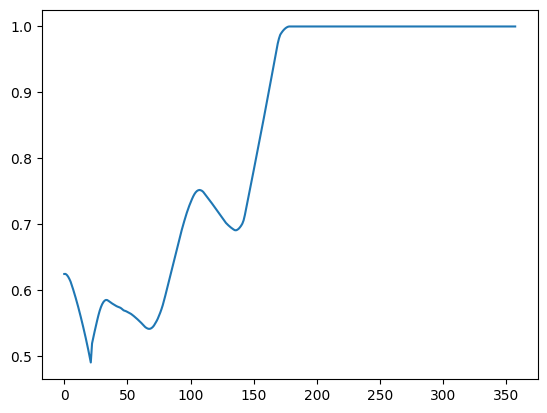

In [42]:
# ROC AUC score
sample_1 = 'N'
sample_2 = 'A'
fs = config.FS/config.DOWNSAMPLE
roc = []
a_df = df[(df['sample']==sample_1)]
b_df = df[(df['sample']==sample_2)]
for i in range(len(a_df)-100):
    y_a = a_df['sample'].replace([sample_1],[0]).values[i:i+100]
    y_b = b_df['sample'].replace([sample_2],[1]).values[i:i+100]
    y = np.concatenate((y_a,y_b))

    x = np.concatenate((a_df['value'].values[i:i+100],b_df['value'].values[i:i+100]))
    x=np.array([x]).T
    clf = LogisticRegression(solver='liblinear',random_state=2022).fit(x,y)
    roc.append(roc_auc_score(y,clf.decision_function(x)))
plt.plot(roc)

### Stimuli

In [22]:
events_timestamps

NameError: name 'events_timestamps' is not defined

In [ ]:
#def get_mean_fr(task,events,neurons,code,n_test_stim,in_out,x_lim_min,x_lim_max,down_sample,sp_py):
n_test_stimuli = 2
total_events_timestamps = np.zeros((1,(n_test_stim*2)+4))
mean_fr:Dict[str,list] = defaultdict(list)
fs=config.FS
downsample=config.DOWNSAMPLE
fs = fs/downsample
for i,neuron in enumerate(neurons):
    conv_max=0
    fig,ax = plt.subplots(figsize=(10, 3),sharex=True,sharey=True)
    for color,sample,stim in zip(['m','c','r','b'],['A','A','A','A'],['A','B','C','D']):#'A','A','A','A'  'B','B','B','B'  'C','C','C','C'  'D','D','D', 'D'
        target_trials_idx = task[(task['sample_id']==sample) & (task['in_out']==in_out) & (task['n_test_stimuli']>7) & (task['test_stimuli_1']==stim_codes[stim])]['idx_trial'].values
        events_timestamps = firing_rate.select_events_timestamps(sp_py,target_trials_idx, events) # select events timestamps for all trials
        neuron_trials = firing_rate.align_neuron_spikes(target_trials_idx, sp_py, neuron, events_timestamps[:,2])
        shift_events = (events_timestamps.T-events_timestamps.T[2]).T
        total_events_timestamps = np.concatenate((total_events_timestamps,shift_events))
        conv,trial_average_sp, sorted_sp_neuron = fr_between_events(neuron_trials,kernel,fs,downsample)
        #conv = np.convolve(trial_average_sp,kernel,mode='same')*config.FS
        conv_max=conv_max if conv_max > max(conv) else max(conv)
        # add values to dict
        ev = np.floor(np.nanmean((events_timestamps.T-events_timestamps.T[2]).T,axis=0)/downsample)[2:]
        if np.sum(conv)==0:
            conv_plot = np.zeros(max(ev)+1)
        else:
            conv_plot = conv[int(abs(sorted_sp_neuron[0])/downsample):]
        ev = np.floor(np.nanmean((events_timestamps.T-events_timestamps.T[2]).T,axis=0)/downsample)[2:]
        ev_a = np.zeros(len(conv_plot))
        ev_a[ev.tolist()]=1
        mean_fr['neuron'] += [i+1] * len(conv_plot)
        mean_fr['conv'] += conv_plot.tolist()
        mean_fr['mean_idx_events'] += ev_a.tolist()
        mean_fr['sample'] += [sample] * len(conv_plot)
        mean_fr['stim'] += [stim] * len(conv_plot)
        mean_fr['n_test_stimuli'] += [n_test_stim] * len(conv_plot)
        # plot
        ax.plot((np.arange(len(conv))+sorted_sp_neuron[0]/downsample) / fs, conv,palette[stim])

    mean_idx_events = np.nanmean(total_events_timestamps[1:],axis=0)/downsample
    ax.vlines(mean_idx_events[0]/fs, 0, conv_max ,color="g", linestyles="solid")
    ax.vlines(mean_idx_events[1]/fs, 0, conv_max ,color="r", linestyles="dashed")
    ax.vlines(mean_idx_events[2]/fs, 0, conv_max ,color="k", linestyles="solid")
    for n in range(3,len(events),2):
        ax.vlines(mean_idx_events[n]/fs, 0, conv_max ,color="b", linestyles="dashed")
        ax.vlines(mean_idx_events[n+1]/fs, 0, conv_max ,color="k", linestyles="solid")
    
    ax.set_title('sample: %s  in_out: %d'%(sample,in_out))
    ax.set_xlim(x_lim_min, x_lim_max)
    fig.legend(['Stim A','Stim B','Stim C','Stim D','Fixation','Sample on','Off','On'], fontsize=9)
    fig.suptitle("Neuron %d" % (i + 1), x=0)
    plt.show()
mean_fr=pd.DataFrame(mean_fr)


In [ ]:
n_neuron = 8
anova_table = mean_fr[mean_fr['neuron']==n_neuron][['sample','stim','conv','mean_idx_events']].reset_index(drop=True).reset_index()

In [ ]:
df:Dict[str,list] = defaultdict(list)

for n_sample in ['A','B','C','D','N']: 
    a=anova_table[np.logical_and(anova_table['stim']=='A',anova_table['sample']==n_sample)].reset_index(drop=True)
    b=anova_table[np.logical_and(anova_table['stim']=='B',anova_table['sample']==n_sample)].reset_index(drop=True)
    c=anova_table[np.logical_and(anova_table['stim']=='C',anova_table['sample']==n_sample)].reset_index(drop=True)
    d=anova_table[np.logical_and(anova_table['stim']=='D',anova_table['sample']==n_sample)].reset_index(drop=True)
    # idx events
    a_ev_idx = a.index[a['mean_idx_events']!=0].values 
    B_ev_idx = b.index[b['mean_idx_events']!=0].values
    C_ev_idx = c.index[c['mean_idx_events']!=0].values
    D_ev_idx = d.index[d['mean_idx_events']!=0].values
    # conv between during sample presentation
    a_event = a['conv'].values[a_ev_idx[1]:a_ev_idx[2]]
    b_event = b['conv'].values[B_ev_idx[1]:B_ev_idx[2]]
    c_event = c['conv'].values[C_ev_idx[1]:C_ev_idx[2]]
    d_event = d['conv'].values[D_ev_idx[1]:D_ev_idx[2]]

    df['color'] += np.concatenate((['c1']*len(a_event),['c5']*len(b_event),['c1']*len(c_event),['c5']*len(d_event)),dtype=str).tolist()
    df['orientation'] +=np.concatenate((['o1']*len(a_event),['o1']*len(b_event),['o5']*len(c_event),['o5']*len(d_event)),dtype=str).tolist()
    df['sample'] +=[n_sample] * (len(a_event)+len(b_event)+len(c_event)+len(d_event))
    df['value'] +=np.concatenate((a_event,b_event,c_event,d_event)).tolist()


In [ ]:
df = pd.DataFrame(df)

In [ ]:
sns.boxplot(x='sample',y='value',data=df)#,hue='orientation'

In [ ]:
a_all = df[df['sample']=='A']['value'].values
b_all = df[df['sample']=='B']['value'].values
c_all = df[df['sample']=='C']['value'].values
d_all = df[df['sample']=='D']['value'].values

stats.f_oneway(a_all,b_all,c_all,d_all)

In [ ]:
res = bk_stat()
res.tukey_hsd(df=df, res_var='value',xfac_var='sample',anova_model='value~C(sample)')
res.tukey_summary

In [ ]:
model_str = 'value ~ C(color)+C(orientation)+C(sample) + C(color):C(orientation):C(sample)'
model = ols(model_str, data = df).fit()

In [ ]:
anova_res = sm.stats.anova_lm(model,type=2)

In [ ]:
anova_res

### Post-hoc

In [ ]:
res = bk_stat()

In [ ]:
res.tukey_hsd(df=df, res_var='value',xfac_var='color',anova_model=model_str)
res.tukey_summary

In [ ]:
res.tukey_hsd(df=df, res_var='value',xfac_var='orientation',anova_model=model_str)
res.tukey_summary

In [ ]:
res.tukey_hsd(df=df, res_var='value',xfac_var='sample',anova_model=model_str)
res.tukey_summary

In [ ]:
res.tukey_hsd(df=df, res_var='value',xfac_var=['sample','color'],anova_model=model_str)
a=res.tukey_summary
a

In [ ]:
res.tukey_hsd(df=df, res_var='value',xfac_var=['sample','orientation'],anova_model=model_str)
a=res.tukey_summary
a

In [ ]:
res.tukey_hsd(df=df, res_var='value',xfac_var=['sample','orientation','color'],anova_model=model_str)
a=res.tukey_summary
a.head(20)